In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "jiaxinliang1023" 
os.environ['KAGGLE_KEY'] = "efb31e21263b2e472fb222f5c6859d57"  
!kaggle competitions download -c plant-pathology-2020-fgvc7 #下载数据集


plant-pathology-2020-fgvc7.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
#导入各种库，pandas用于数据处理，numpy用于计算，matplotlib.pyplot/seaborn/cv2用于可视化。

import tensorflow as tf #TensorFlow是深度学习的框架
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import cv2
import pathlib #pathlib用于处理文件路径
import os #导入os库，os库提供了与操作系统交互的函数

from keras.metrics import Precision, Recall
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler #后续修改代码bug时询问了Chat GPT，同时也对这里进行了修改


2023-06-16 00:13:28.004752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset_folder = os.path.join("/Users/liangjiaxin/miniconda3/envs/coding3/lib/python3.9/site-packages/kaggle/input/plant-pathology-2020-fgvc7")
datasetObject = pd.read_csv(os.path.join(dataset_folder, "train.csv")) #校准数据集路径


In [4]:
datasetObject.head()#此处代码没有修改

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [5]:
imagesDataset = pathlib.Path(os.path.join(dataset_folder, "images"))
listImages = list(imagesDataset.glob("*.*")) #此处代码没有修改


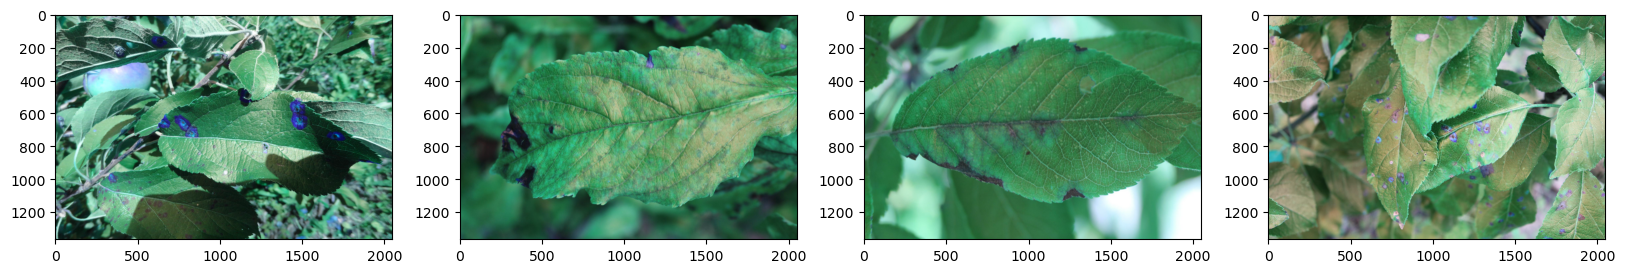

In [6]:
plt.figure(figsize = (20, 6)) #留四个图像的空间来生成预览图
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = cv2.imread(str(listImages[i]))
    plt.imshow(img)
plt.show()


In [7]:
images_id_csv = datasetObject['image_id']
healthy_csv = datasetObject['healthy']
multiple_diseases_csv = datasetObject['multiple_diseases']
rust_csv = datasetObject['rust']
scab_csv = datasetObject['scab'] #设置变量

In [8]:
images = []
labels = []
for index, values in enumerate(images_id_csv):
    img = cv2.imread(os.path.join(dataset_folder, "images", "{}.jpg".format(values)))
    img = cv2.resize(img, (100, 100)) #合适的图像大小
    img = img/255
    labels.append([healthy_csv[index], multiple_diseases_csv[index], rust_csv[index],
                 scab_csv[index]])
    images.append(img) #images列表将包含处理后的图像数据，labels列表将包含与每个图像对应的标签信息


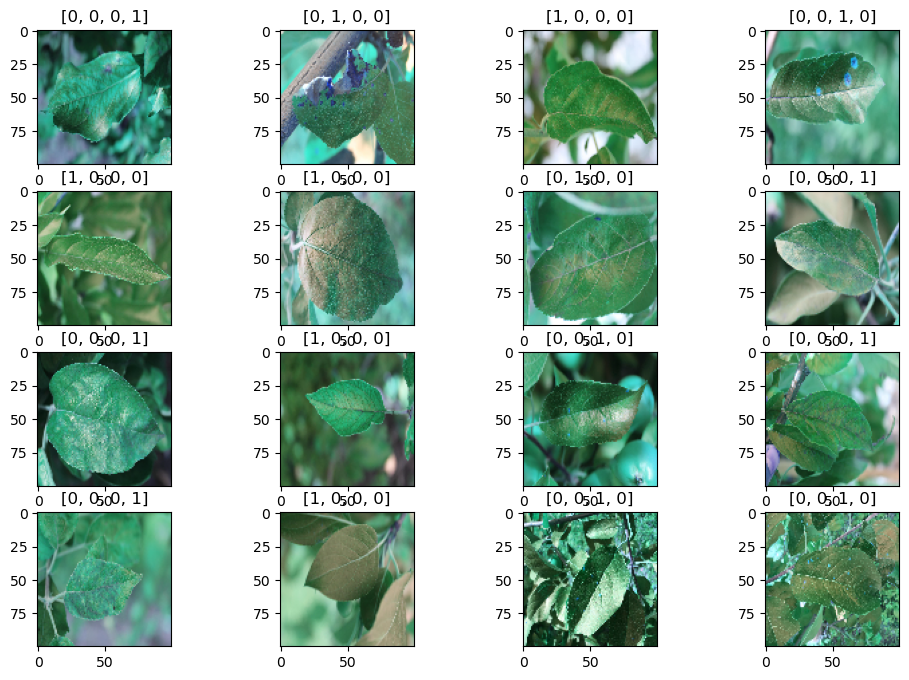

In [9]:
plt.figure(figsize = (12, 8)) #多个预览图可以小一点
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i]) #图像
  plt.title(labels[i]) #标题
plt.show() #没有改

In [10]:
img_data_g = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.35,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rescale=None) #无改动

In [11]:
images_after_aug = [] #增强图像并对应
labels_after_aug = []
for index, image in enumerate(images):
  for i in range(9):
      img = img_data_g.flow(np.reshape(image, (1, 100, 100, 3))).next()
      images_after_aug.append(np.reshape(img, (100, 100, 3)))
      labels_after_aug.append(labels[index])
labels = np.asarray(labels_after_aug)
images = np.asarray(images_after_aug) #没有改动

In [12]:
images.shape #看看家产

(16389, 100, 100, 3)

/Users/liangjiaxin/miniconda3/envs/coding3/lib/python3.9/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


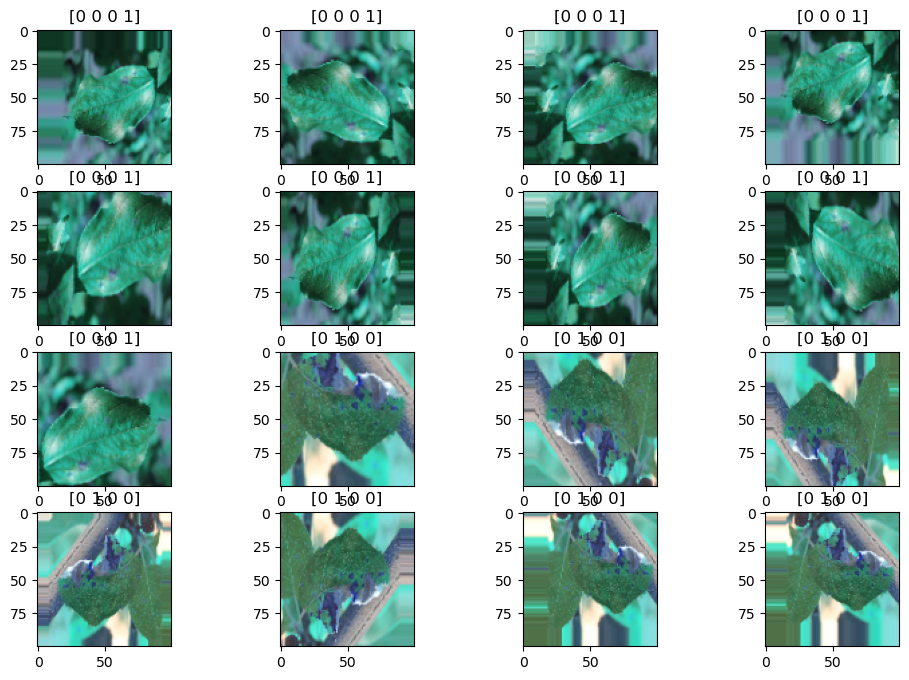

In [13]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show() 

In [14]:
d = tf.keras.applications.DenseNet121(include_top=False,
                   input_shape=(100,100,3), #设置输入文件大小
                   pooling=None,
                   weights='imagenet')
for i in d.layers:
  i.trainable = True  #没有改动

In [15]:
output_avg = tf.keras.layers.GlobalAveragePooling2D()(d.output)
output_max = tf.keras.layers.GlobalMaxPooling2D()(d.output)
m = tf.keras.layers.minimum([output_avg, output_max])
m = tf.keras.layers.Dropout(0.5)(m)
m = tf.keras.layers.Dense(128, activation = "sigmoid")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(256, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(512, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(4, activation= "softmax")(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)
m.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
          loss = "categorical_crossentropy", 
          metrics =["accuracy", 
                     Precision(name='precision'), 
                     Recall(name='recall')])
m.summary() #没有改动

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

In [16]:
from sklearn.model_selection import train_test_split #此处没有改动
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 42)

In [17]:
x_train.shape #没有改动

(13930, 100, 100, 3)

In [18]:
x_test.shape #没有改动

(2459, 100, 100, 3)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LambdaCallback

def save_prediction_image(epoch, logs):
    # 在测试集上进行预测
    predictions = m.predict(x_test)
    # 为每个预测创建一个图像
    for i, prediction in enumerate(predictions):
        # 创建一个空白图像
        image = np.zeros((100, 100, 3))
        # 使用预测的类别概率来填充图像的各个部分
        for j, class_probability in enumerate(prediction):
            image[j*25:(j+1)*25, :, :] = class_probability
        # 保存图像
        plt.imsave(f'images/prediction_{i}_at_epoch_{epoch}.png', image)

history = m.fit(x_train, y_train, epochs = 10, batch_size = 32,
                callbacks = [
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, mode = 'min',
                                                  patience= 1),
                    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min', restore_best_weights = True),
                    LambdaCallback(on_epoch_end=save_prediction_image)
                ])



Epoch 1/30
436/436 [==============================] - 1152s 3s/step - loss: 0.5871 - accuracy: 0.7930 - precision: 0.8560 - recall: 0.7328 - lr: 0.0010
Epoch 2/30
436/436 [==============================] - 1114s 3s/step - loss: 0.3326 - accuracy: 0.8967 - precision: 0.9172 - recall: 0.8788 - lr: 0.0010
Epoch 3/30
436/436 [==============================] - 1185s 3s/step - loss: 0.2726 - accuracy: 0.9131 - precision: 0.9321 - recall: 0.8988 - lr: 0.0010
Epoch 4/30
436/436 [==============================] - 1167s 3s/step - loss: 0.2265 - accuracy: 0.9267 - precision: 0.9380 - recall: 0.9156 - lr: 0.0010
Epoch 5/30
436/436 [==============================] - 1200s 3s/step - loss: 0.2025 - accuracy: 0.9356 - precision: 0.9473 - recall: 0.9235 - lr: 0.0010
Epoch 6/30
436/436 [==============================] - 1177s 3s/step - loss: 0.1667 - accuracy: 0.9457 - precision: 0.9552 - recall: 0.9373 - lr: 0.0010
Epoch 7/30
436/436 [==============================] - 1131s 3s/step - loss: 0.1634 - acc

In [68]:
# 将一系列训练进展图像转换为动画，并通过显示动画的方式进行可视化。
from PIL import Image

# 获取文件名
images = sorted(glob.glob('images/*.png'))

# 创建一个PIL对象给每个图片文件
pil_images = []
for image in images:
    with Image.open(image) as img:
        img_with_palette = img.convert('P')  # Convert the image to P mode
        pil_images.append(img_with_palette.copy())

# 保存成gif（由于直接让他在这里显示似乎会让文件超过25MB，所以我仅选择了保存，我会把gif放在视频里
pil_images[0].save('training_progress.gif', save_all=True, append_images=pil_images[1:], optimize=False, duration=500, loop=0)


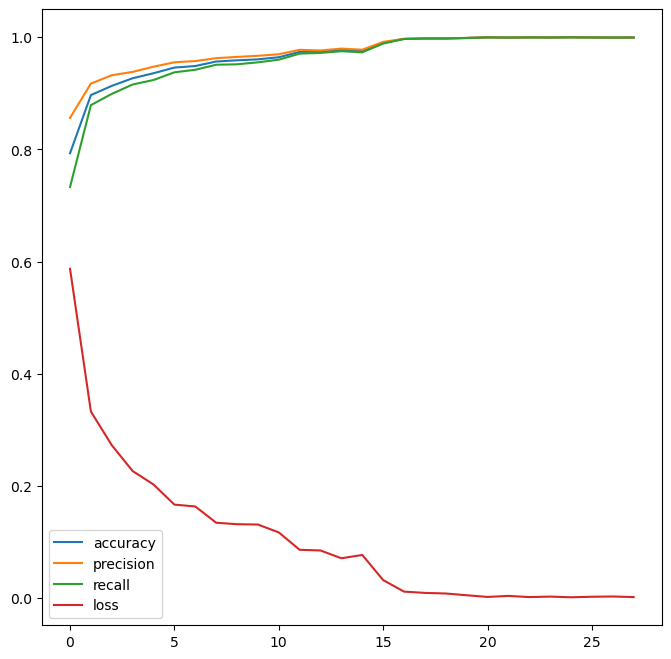

In [69]:
plt.figure(figsize = (8,8))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['precision'], label = "precision")
plt.plot(history.history['recall'], label = "recall")
plt.plot(history.history['loss'], label = "loss") # 原本只有accuracy，我询问chat GPT能不能让视图更丰富，他的回答是可以多加几个数值
plt.legend() # 标签

In [24]:
m.evaluate(x_test, y_test, batch_size= 32)#评估

77/77 [==============================] - 48s 582ms/step - loss: 0.0782 - accuracy: 0.9854 - precision: 0.9862 - recall: 0.9845


[0.07821664214134216,
 0.9853599071502686,
 0.9861507415771484,
 0.9845465421676636]

In [25]:
y_pred = m.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1) # 没有改

77/77 [==============================] - 41s 529ms/step


In [26]:
y_pred #没有改

array([3, 3, 2, ..., 2, 0, 0])

In [27]:
y_test = np.argmax(y_test, axis = 1) # 无改动

In [28]:
cnn_standard_acc = accuracy_score(y_pred, y_test)
print(cnn_standard_acc)

0.9853599023993493


In [29]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       730
           1       0.88      0.91      0.89       106
           2       1.00      0.99      0.99       835
           3       0.98      0.99      0.98       788

    accuracy                           0.99      2459
   macro avg       0.96      0.97      0.97      2459
weighted avg       0.99      0.99      0.99      2459



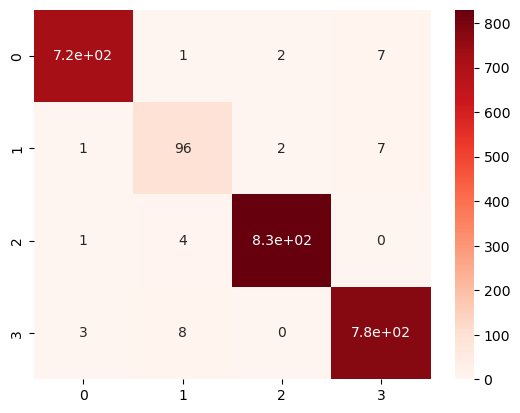

In [70]:
import seaborn as sns

def generate_confusion_matrix(y_pred, y_test):
    c = tf.math.confusion_matrix(y_pred, y_test)
    sns.heatmap(c, annot=True, cmap='Reds') #这里我尝试将热图设定为红色调

# 调用函数生成混淆矩阵热图
generate_confusion_matrix(y_pred, y_test)


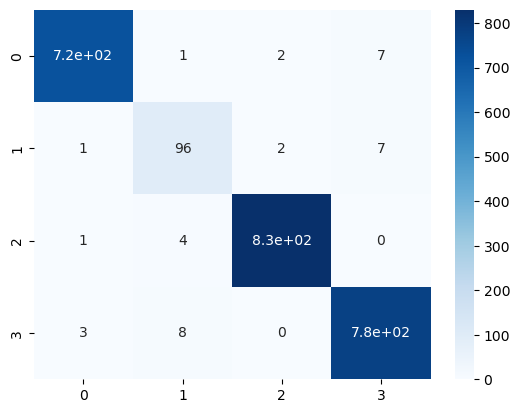

In [71]:
import seaborn as sns

def generate_confusion_matrix(y_pred, y_test):
    c = tf.math.confusion_matrix(y_pred, y_test)
    sns.heatmap(c, annot=True, cmap='Blues') #这里我尝试将热图设定为蓝色调

# 调用函数生成混淆矩阵热图
generate_confusion_matrix(y_pred, y_test)


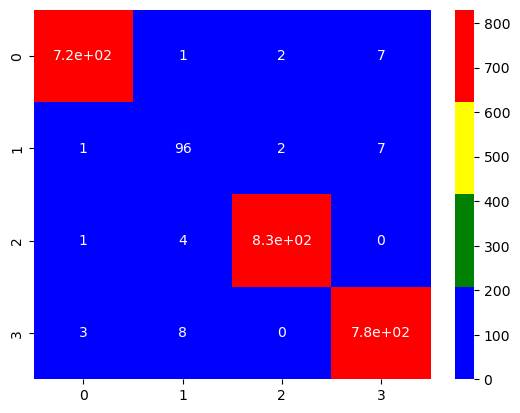

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def generate_confusion_matrix(y_pred, y_test):
    c = tf.math.confusion_matrix(y_pred, y_test)
    
    # 自定义颜色映射，每个值对应不同的颜色
    colors = ['blue', 'green', 'yellow', 'red']
    cmap = ListedColormap(colors)
    
    sns.heatmap(c, annot=True, cmap=cmap)

# 调用函数生成混淆矩阵热图
generate_confusion_matrix(y_pred, y_test)
#这个颜色有点丑。。。